In [ ]:
!pip install numpy pandas scikit-learn

In [ ]:
import pandas as pd
import os

# Load the CSV into a DataFrame
df = pd.read_csv("Food_Recipe.csv")

print(f"Dataset Shape: {df.shape}")

Dataset Shape: (4986, 3)


In [ ]:
# Drop rows with missing ingredients
df = df.dropna(subset=["ingredients_name"])

# Display the dataset shape
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (4984, 3)


In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

# Tokenize the ingredients into lists of words
df['ingredients_tokens'] = df['ingredients_name'].apply(lambda x: x.lower().split(', '))

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=df['ingredients_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model (optional)
word2vec_model.save("word2vec_recipes.model")


In [ ]:
import numpy as np

# Function to get the vector for an ingredient
def get_ingredient_vector(ingredient, model):
    try:
        return model.wv[ingredient]
    except KeyError:
        # Return a zero vector if the ingredient is not in the vocabulary
        return np.zeros(model.vector_size)

# Function to get the vector for a list of ingredients
def get_recipe_vector(ingredients_list, model):
    vectors = [get_ingredient_vector(ing, model) for ing in ingredients_list]
    return np.mean(vectors, axis=0)

# Recommendation function
def recommend_word2vec(input_ingredients, top_n=5):
    input_tokens = input_ingredients.lower().split(', ')
    input_vec = get_recipe_vector(input_tokens, word2vec_model)

    # Calculate cosine similarity with all recipes
    similarities = []
    for _, row in df.iterrows():
        recipe_vec = get_recipe_vector(row['ingredients_tokens'], word2vec_model)
        similarity = np.dot(input_vec, recipe_vec) / (np.linalg.norm(input_vec) * np.linalg.norm(recipe_vec))
        similarities.append(similarity)

    # Get top-k recommendations
    df['similarity'] = similarities
    recommendations = df.sort_values(by='similarity', ascending=False).head(top_n)
    return recommendations[['name', 'ingredients_name', 'similarity']]

# Example usage
input_ingredients = "chicken, garlic, yogurt"
print("\nWord2Vec Recommendations:")
print(recommend_word2vec(input_ingredients))



Word2Vec Recommendations:
                                                   name  \
420   Mumbai Style Tawa Pulao Recipe With Moong Sprouts   
1029                         Chilli Garlic Toast Recipe   
598     Corn & Soy Quesadillas with Spicy Mexican Salsa   
3116      Vegan Burger Recipe With Beans And Tofu Patty   
1844  Avengers Cheeseburger Recipe-Aloo Tikki Burger...   

                                       ingredients_name  similarity  
420   Brown Rice, Ginger, Garlic, Green Bell Pepper ...    0.998864  
1029  Herb Butter, Green Chilli, Garlic, Whole Wheat...    0.998542  
598   Tortillas, Sweet corn, Soybeans (Whole Soya da...    0.998195  
3116  Moth Dal (Matki), Kala Chana (Brown Chickpeas)...    0.998181  
1844  Potatoes (Aloo), Onions, Green Bell Pepper (Ca...    0.998131  


In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np


# Load the dataset
def load_dataset(file_path):
    """Load the recipe dataset from a CSV file."""
    try:
        dataset = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with {len(dataset)} recipes.")
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Preprocess ingredients
def preprocess_ingredients(dataset):
    """Combine ingredients into a single string for each recipe."""
    dataset['ingredients_combined'] = dataset['ingredients_name'].fillna('') + ' ' + dataset['ingredients_quantity'].fillna('')
    return dataset

# Build the Count matrix
def build_count_matrix(dataset, column):
    """Build a CountVectorizer matrix based on the given column."""
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(dataset[column])
    return count_matrix, vectorizer

# Apply SVD for dimensionality reduction
def apply_svd(count_matrix, n_components=100):
    """Apply SVD to reduce the dimensionality of the CountVectorizer matrix."""
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(count_matrix)
    return reduced_matrix, svd


# Ingredient-based recommendation (SVD)
def recommend_by_ingredients_svd(user_ingredients, count_matrix, vectorizer, svd, dataset, top_n=5):
    """Recommend recipes based on user-entered ingredients using SVD."""
    user_count = vectorizer.transform([user_ingredients])
    user_reduced = svd.transform(user_count)
    cosine_similarities = cosine_similarity(user_reduced, svd.transform(count_matrix)).flatten()
    recommendations = cosine_similarities.argsort()[-top_n:][::-1]
    return dataset.iloc[recommendations]

# Recipe-based recommendation (SVD, partial name search)
def recommend_by_recipe_svd(recipe_name, count_matrix, vectorizer, svd, dataset, top_n=5):
    """Recommend similar recipes based on a partial recipe name using SVD."""
    matching_recipes = dataset[dataset['name'].str.contains(recipe_name, case=False, na=False)]
    if len(matching_recipes) == 0:
        print("No recipes found matching the given name.")
        return None

    if len(matching_recipes) >1:
        print("Multiple recipes found matching the given name. Choose the first one")

    recipe_index = matching_recipes.index[0]

    recipe_vector = svd.transform(count_matrix[recipe_index])
    cosine_similarities = cosine_similarity(recipe_vector, svd.transform(count_matrix)).flatten()
    similar_recipes = cosine_similarities.argsort()[-top_n-1:][::-1][1:]
    return dataset.iloc[similar_recipes]


# Main function
if __name__ == "__main__":
    # Locate the dataset path on Kaggle
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    # Update this to match your dataset path
    file_path = '/content/Food_Recipe.csv'

    dataset = load_dataset(file_path)

    if dataset is not None:
        # Preprocess ingredients
        dataset = preprocess_ingredients(dataset)

        # Build CountVectorizer matrix
        count_matrix, vectorizer = build_count_matrix(dataset, 'ingredients_combined')

        # Apply SVD for dimensionality reduction
        n_components = 100  # You can adjust this number as needed
        reduced_matrix, svd = apply_svd(count_matrix, n_components)

        # Model explanation
        print(f"\nWe'll use CountVectorizer to vectorize the ingredient lists, \napply SVD for dimensionality reduction to {n_components} components, and then calculate similarity using cosine similarity.")

        # User interaction
        print("\n1. Recommend recipes based on ingredients.")
        print("2. Recommend recipes based on a similar recipe.")
        choice = int(input("Choose an option (1 or 2): "))

        if choice == 1:
            user_ingredients = input("Enter ingredients (comma-separated): ")
            recommendations = recommend_by_ingredients_svd(user_ingredients, count_matrix, vectorizer, svd, dataset)
            print("\nTop recommended recipes:")
            print(recommendations[['name', 'description', 'cuisine']])
        elif choice == 2:
            recipe_name = input("Enter the recipe name: ")
            recommendations = recommend_by_recipe_svd(recipe_name, count_matrix, vectorizer, svd, dataset)
            if recommendations is not None:
                print("\nTop similar recipes:")
                print(recommendations[['name', 'description', 'cuisine']])
        else:
            print("Invalid choice.")

Error loading dataset: Error tokenizing data. C error: EOF inside string starting at row 2659


In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



# Preprocess ingredients
def preprocess_ingredients(dataset):
    """Combine ingredients into a single string for each recipe."""
    dataset['ingredients_combined'] = dataset['ingredients_name'].fillna('') + ' ' + dataset['ingredients_quantity'].fillna('')
    return dataset

# Build the TF-IDF matrix
def build_tfidf_matrix(dataset, column):
    """Build a TF-IDF matrix based on the given column."""
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(dataset[column])
    return tfidf_matrix, vectorizer

# Ingredient-based recommendation
def recommend_by_tf(user_ingredients, tfidf_matrix, dataset, top_n=5):
    """Recommend recipes based on user-entered ingredients."""
    user_tfidf = vectorizer.transform([user_ingredients])
    cosine_similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()
    recommendations = cosine_similarities.argsort()[-top_n:][::-1]
    return dataset.iloc[recommendations]

# Recipe-based recommendation
def recommend_by_recipe(recipe_name, tfidf_matrix, dataset, top_n=5):
    """Recommend similar recipes based on a given recipe."""
    recipe_index = dataset[dataset['name'] == recipe_name].index
    if len(recipe_index) == 0:
        print("Recipe not found in the dataset.")
        return None
    recipe_index = recipe_index[0]
    cosine_similarities = cosine_similarity(tfidf_matrix[recipe_index], tfidf_matrix).flatten()
    similar_recipes = cosine_similarities.argsort()[-top_n-1:][::-1][1:]  # Exclude the recipe itself
    return dataset.iloc[similar_recipes]

# Main function
if __name__ == "__main__":
    # Locate the dataset path on Kaggle
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    # Update this to match your dataset path
    file_path = '/kaggle/input/recipe/Food_Recipe.csv'

    dataset  = pd.read_csv("Food_Recipe.csv")

    if dataset is not None:
        # Preprocess ingredients
        dataset = preprocess_ingredients(dataset)

        # Build TF-IDF matrix
        tfidf_matrix, vectorizer = build_tfidf_matrix(dataset, 'ingredients_combined')
        # model explication
        print("\nWe'll use TF-IDF (Term Frequency-Inverse Document Frequency) to vectorize the ingredient lists and calculate similarity using cosine similarity.")
        # User interaction
        print("\n1. Recommend recipes based on ingredients.")
        print("2. Recommend recipes based on a similar recipe.")
        choice = int(input("Choose an option (1 or 2): "))

        if choice == 1:
            user_ingredients = input("Enter ingredients (comma-separated): ")
            recommendations = recommend_by_tf(user_ingredients, tfidf_matrix, dataset)
            print("\nTop recommended recipes:")
            print(recommendations[['name', 'description', 'cuisine']])
        elif choice == 2:
            recipe_name = input("Enter the recipe name: ")
            recommendations = recommend_by_recipe(recipe_name, tfidf_matrix, dataset)
            if recommendations is not None:
                print("\nTop similar recipes:")
                print(recommendations[['name', 'description', 'cuisine']])
        else:
            print("Invalid choice.")

ParserError: Error tokenizing data. C error: EOF inside string starting at row 2659

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Chargement du dataset
data = pd.read_csv('Food_Recipe.csv')  # Remplacez par le chemin vers votre fichier
data['ingredients'] = data['ingredients_name'].fillna('') + ' ' + data['ingredients_quantity'].fillna('')
data['ingredients'] = data['ingredients'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower()

# Vectorisation des ingrédients
vectorizer = CountVectorizer(stop_words='english')
ingredient_vectors = vectorizer.fit_transform(data['ingredients'])

# Modèle KNN pour les recommandations
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(ingredient_vectors)

# Fonction pour calculer les scores de similarité
def evaluate_recommendations(input_vector, recommended_indices):
    similarities = cosine_similarity(input_vector, ingredient_vectors[recommended_indices])
    return similarities.flatten()

def recommend_by_knn(ingredients_list, data, top_n=5):
    input_vector = vectorizer.transform([ingredients_list.lower()])
    distances, indices = knn.kneighbors(input_vector, n_neighbors=top_n)
    recommended_recipes = data.iloc[indices[0]]['name']
    scores = evaluate_recommendations(input_vector, indices[0])
    return [(recipe, score) for recipe, score in zip(recommended_recipes, scores)]



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

def create_ground_truth_optimized(df):
    # Vectorize the ingredients using CountVectorizer
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
    ingredient_vectors = vectorizer.fit_transform(df['ingredients_name'])

    # Compute pairwise cosine similarity
    cosine_sim = cosine_similarity(ingredient_vectors)

    # Generate ground truth based on a similarity threshold
    ground_truth = {}
    for idx, dish in enumerate(df['name']):
        similar_indices = cosine_sim[idx].argsort()[::-1][1:]  # Exclude self-match
        similar_dishes = df.iloc[similar_indices][cosine_sim[idx][similar_indices] > 0.5]['name']
        ground_truth[dish] = set(similar_dishes)
        ground_truth = dict(list(ground_truth.items())[:10])


    return ground_truth

In [ ]:
def precision_at_k(recommended_dishes, relevant_dishes, k):
    recommended_dishes = recommended_dishes[:k]
    relevant_dishes = set(relevant_dishes)
    if not relevant_dishes:
        return 0.0
    return len(set(recommended_dishes) & relevant_dishes) / len(recommended_dishes)

def recall_at_k(recommended_dishes, relevant_dishes, k):
    relevant_dishes = set(relevant_dishes)
    if not relevant_dishes:
        return 0.0
    return len(set(recommended_dishes) & relevant_dishes) / len(relevant_dishes)

def mean_reciprocal_rank(recommended_dishes, relevant_dishes):
    for i, dish in enumerate(recommended_dishes, start=1):
        if dish in relevant_dishes:
            return 1 / i
    return 0.0


In [ ]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def precision_at_k(recommended, relevant, k):
    """Calculate Precision@K."""
    recommended_at_k = recommended[:k]
    hits = sum(1 for item in recommended_at_k if item in relevant)
    return hits / k

def recall_at_k(recommended, relevant, k):
    """Calculate Recall@K."""
    recommended_at_k = recommended[:k]
    hits = sum(1 for item in recommended_at_k if item in relevant)
    return hits / len(relevant) if relevant else 0

def mean_reciprocal_rank(recommended, relevant):
    """Calculate Mean Reciprocal Rank (MRR)."""
    for i, rec in enumerate(recommended):
        if rec in relevant:
            return 1 / (i + 1)
    return 0

def evaluate_model(recommend_function, test_data, *args, k=5):
    """
    Evaluate a recommendation model on Precision@K, Recall@K, and MRR.

    Parameters:
    - recommend_function: The recommendation function to evaluate.
    - test_data: List of test cases, where each case is a tuple of
                 (user_ingredients, relevant_recipes).
    - *args: Additional arguments for the recommend_function.
    - k: Number of recommendations to evaluate.

    Returns:
    - A dictionary containing average precision@k, recall@k, and MRR.
    """
    precision_scores = []
    recall_scores = []
    mrr_scores = []

    for user_ingredients, relevant_recipes in test_data:
        # Get recommendations
        recommendations = recommend_function(user_ingredients, *args)
        recommended_names = recommendations['name'].tolist() if hasattr(recommendations, 'name') else recommendations

        # Calculate metrics
        precision_scores.append(precision_at_k(recommended_names, relevant_recipes, k))
        recall_scores.append(recall_at_k(recommended_names, relevant_recipes, k))
        mrr_scores.append(mean_reciprocal_rank(recommended_names, relevant_recipes))

    # Return average metrics
    return {
        'precision@k': np.mean(precision_scores),
        'recall@k': np.mean(recall_scores),
        'mrr': np.mean(mrr_scores),
    }


In [ ]:
# Define your test data
test_data = [
    ("tomato, basil, mozzarella", ["Caprese Salad", "Margherita Pizza"]),
    ("chicken, garlic, ginger", ["Chicken Curry", "Garlic Chicken"]),
    ("flour, sugar, eggs", ["Pancakes", "Cake"]),
    ("rice, soy sauce, egg", ["Fried Rice", "Egg Fried Rice"]),
]

# Evaluate SVD Model
results_svd = evaluate_model(
    recommend_by_ingredients_svd,
    test_data,
    count_matrix,
    vectorizer,
    svd,
    dataset,
    k=5
)
print("SVD Model Results:", results_svd)

# Evaluate TF-IDF Model
results_tfidf = evaluate_model(
    recommend_by_tf,
    test_data,
    tfidf_matrix,
    dataset,
    k=5
)
print("TF-IDF Model Results:", results_tfidf)

# Evaluate KNN Model
results_knn = evaluate_model(
    recommend_by_knn,
    test_data,
    dataset,
    k=5
)
print("KNN Model Results:", results_knn)


SVD Model Results: {'precision@k': 0.0, 'recall@k': 0.0, 'mrr': 0.0}
TF-IDF Model Results: {'precision@k': 0.0, 'recall@k': 0.0, 'mrr': 0.0}


ValueError: X has 3501 features, but NearestNeighbors is expecting 3370 features as input.

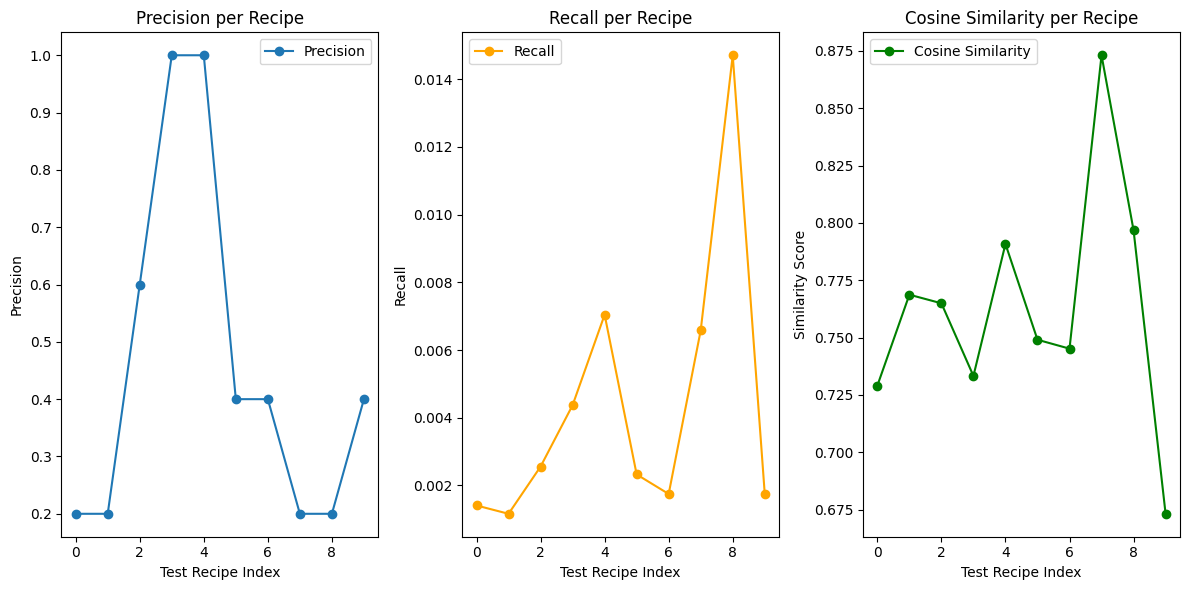

Average Precision: 0.46
Average Recall: 0.00
Average Cosine Similarity: 0.76


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def evaluate_model(dataset, count_matrix, vectorizer, svd, n_samples=10, top_n=5):
    """Evaluate the model and visualize the results."""
    results = {
        'precision': [],
        'recall': [],
        'cosine_similarity': []
    }

    # Randomly sample recipes for evaluation
    sampled_indices = dataset.sample(n=n_samples, random_state=42).index

    for idx in sampled_indices:
        recipe_name = dataset.loc[idx, 'name']
        ingredients = dataset.loc[idx, 'ingredients_combined']

        # Recommendations based on ingredients
        recommended_recipes = recommend_by_ingredients_svd(
            ingredients, count_matrix, vectorizer, svd, dataset, top_n=top_n
        )

        # Calculate cosine similarity for the recommendations
        user_vector = vectorizer.transform([ingredients])
        user_reduced = svd.transform(user_vector)
        similarities = cosine_similarity(user_reduced, svd.transform(count_matrix)).flatten()
        top_similarities = similarities[recommended_recipes.index]
        avg_similarity = np.mean(top_similarities)

        # Dummy ground truth: Assume relevant recipes have the same cuisine
        ground_truth = (dataset['cuisine'] == dataset.loc[idx, 'cuisine']).astype(int)
        predicted = [1 if i in recommended_recipes.index else 0 for i in range(len(dataset))]

        # Precision and Recall
        precision = precision_score(ground_truth, predicted, zero_division=0)
        recall = recall_score(ground_truth, predicted, zero_division=0)

        results['precision'].append(precision)
        results['recall'].append(recall)
        results['cosine_similarity'].append(avg_similarity)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(results['precision'], label='Precision', marker='o')
    plt.title('Precision per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(results['recall'], label='Recall', marker='o', color='orange')
    plt.title('Recall per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['cosine_similarity'], label='Cosine Similarity', marker='o', color='green')
    plt.title('Cosine Similarity per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Similarity Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print average metrics
    print(f"Average Precision: {np.mean(results['precision']):.2f}")
    print(f"Average Recall: {np.mean(results['recall']):.2f}")
    print(f"Average Cosine Similarity: {np.mean(results['cosine_similarity']):.2f}")

# Example usage
if dataset is not None:
    evaluate_model(dataset, count_matrix, vectorizer, svd)


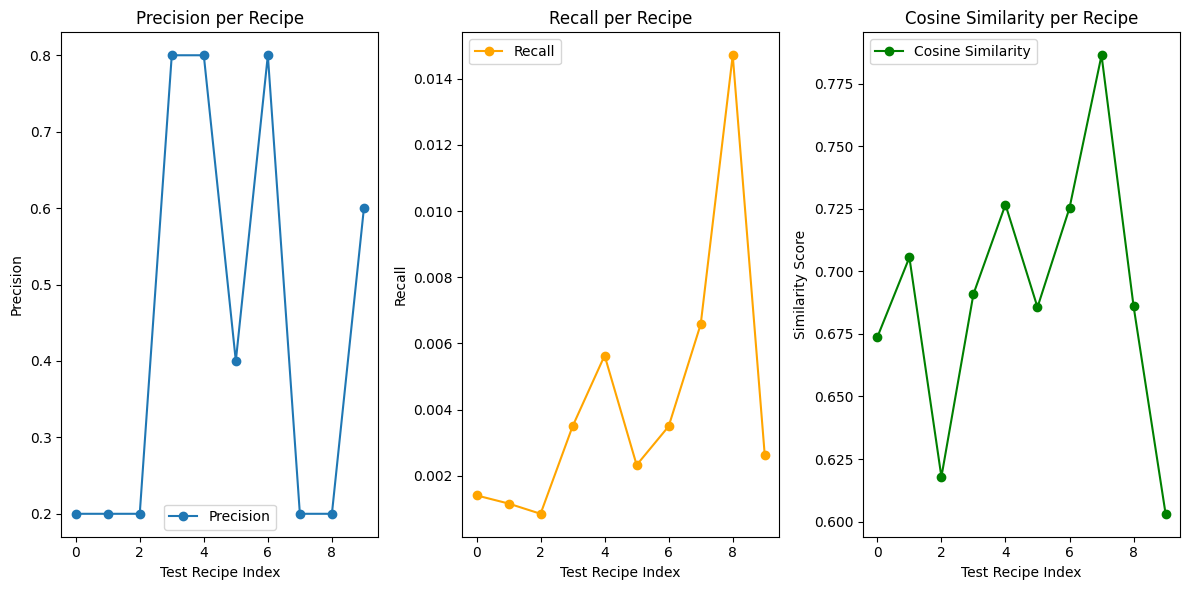

Average Precision: 0.44
Average Recall: 0.00
Average Cosine Similarity: 0.69


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def evaluate_tfidf_model(dataset, tfidf_matrix, vectorizer, n_samples=10, top_n=5):
    """Evaluate the TF-IDF-based model and visualize the results."""
    results = {
        'precision': [],
        'recall': [],
        'cosine_similarity': []
    }

    # Randomly sample recipes for evaluation
    sampled_indices = dataset.sample(n=n_samples, random_state=42).index

    for idx in sampled_indices:
        recipe_name = dataset.loc[idx, 'name']
        ingredients = dataset.loc[idx, 'ingredients_combined']

        # Recommendations based on ingredients
        recommended_recipes = recommend_by_tf(
            ingredients, tfidf_matrix, dataset, top_n=top_n
        )

        # Calculate cosine similarity for the recommendations
        user_tfidf = vectorizer.transform([ingredients])
        similarities = cosine_similarity(user_tfidf, tfidf_matrix).flatten()
        top_similarities = similarities[recommended_recipes.index]
        avg_similarity = np.mean(top_similarities)

        # Dummy ground truth: Assume relevant recipes have the same cuisine
        ground_truth = (dataset['cuisine'] == dataset.loc[idx, 'cuisine']).astype(int)
        predicted = [1 if i in recommended_recipes.index else 0 for i in range(len(dataset))]

        # Precision and Recall
        precision = precision_score(ground_truth, predicted, zero_division=0)
        recall = recall_score(ground_truth, predicted, zero_division=0)

        results['precision'].append(precision)
        results['recall'].append(recall)
        results['cosine_similarity'].append(avg_similarity)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(results['precision'], label='Precision', marker='o')
    plt.title('Precision per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(results['recall'], label='Recall', marker='o', color='orange')
    plt.title('Recall per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['cosine_similarity'], label='Cosine Similarity', marker='o', color='green')
    plt.title('Cosine Similarity per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Similarity Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print average metrics
    print(f"Average Precision: {np.mean(results['precision']):.2f}")
    print(f"Average Recall: {np.mean(results['recall']):.2f}")
    print(f"Average Cosine Similarity: {np.mean(results['cosine_similarity']):.2f}")

# Example usage
if dataset is not None:
    evaluate_tfidf_model(dataset, tfidf_matrix, vectorizer)


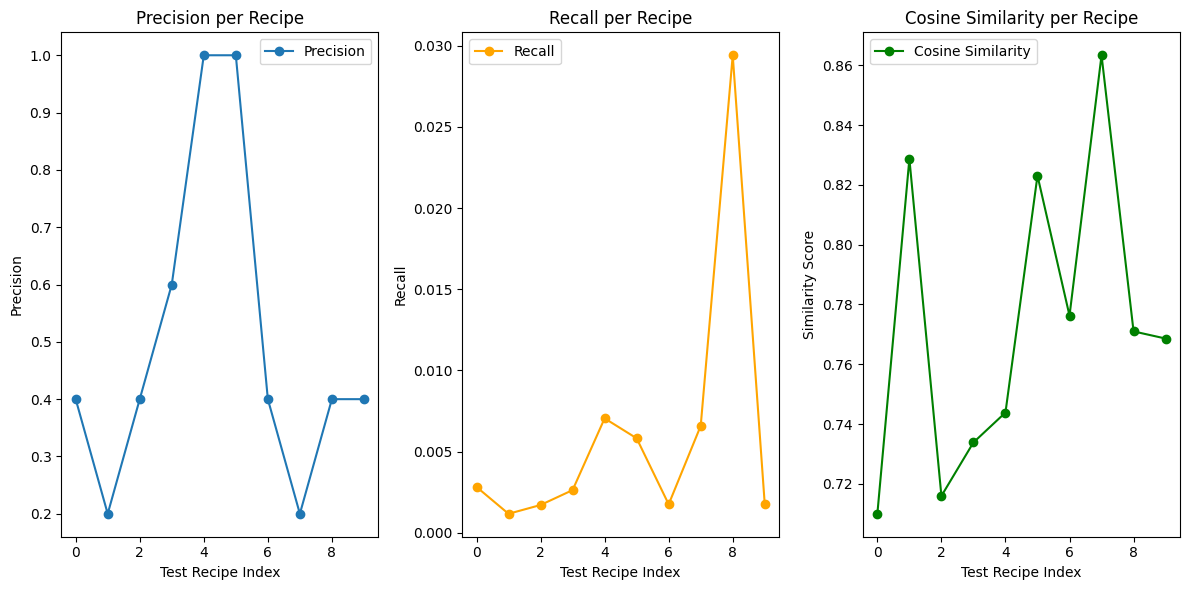

Average Precision: 0.50
Average Recall: 0.01
Average Cosine Similarity: 0.77


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Chargement du dataset
data = pd.read_csv('Food_Recipe.csv')  # Remplacez par le chemin vers votre fichier
data['ingredients'] = data['ingredients_name'].fillna('') + ' ' + data['ingredients_quantity'].fillna('')
data['ingredients'] = data['ingredients'].str.replace(r'[^\w\s]', ' ', regex=True).str.lower()

# Vectorisation des ingrédients
vectorizer = CountVectorizer(stop_words='english')
ingredient_vectors = vectorizer.fit_transform(data['ingredients'])

# Modèle KNN pour les recommandations
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(ingredient_vectors)

# Fonction pour calculer les scores de similarité
def evaluate_recommendations(input_vector, recommended_indices):
    similarities = cosine_similarity(input_vector, ingredient_vectors[recommended_indices])
    return similarities.flatten()

def recommend_by_knn(ingredients_list, data, top_n=5):
    input_vector = vectorizer.transform([ingredients_list.lower()])
    distances, indices = knn.kneighbors(input_vector, n_neighbors=top_n)
    recommended_recipes = data.iloc[indices[0]]['name']
    scores = cosine_similarity(input_vector, ingredient_vectors[indices[0]]).flatten()
    return [(recipe, score) for recipe, score in zip(recommended_recipes, scores)]

# Evaluation function
def evaluate_knn_model(data, n_samples=10, top_n=5):
    """Evaluate the KNN-based model and visualize the results."""
    results = {
        'precision': [],
        'recall': [],
        'cosine_similarity': []
    }

    # Randomly sample recipes for evaluation
    sampled_indices = data.sample(n=n_samples, random_state=42).index

    for idx in sampled_indices:
        ingredients = data.loc[idx, 'ingredients']
        ground_truth_cuisine = data.loc[idx, 'cuisine']

        # Get recommendations
        recommendations = recommend_by_knn(ingredients, data, top_n=top_n)
        recommended_indices = [data[data['name'] == recipe[0]].index[0] for recipe in recommendations]

        # Calculate cosine similarity for the recommendations
        input_vector = vectorizer.transform([ingredients])
        similarities = cosine_similarity(input_vector, ingredient_vectors[recommended_indices]).flatten()
        avg_similarity = np.mean(similarities)

        # Dummy ground truth: Assume relevant recipes have the same cuisine
        ground_truth = (data['cuisine'] == ground_truth_cuisine).astype(int)
        predicted = [1 if i in recommended_indices else 0 for i in range(len(data))]

        # Precision and Recall
        precision = precision_score(ground_truth, predicted, zero_division=0)
        recall = recall_score(ground_truth, predicted, zero_division=0)

        results['precision'].append(precision)
        results['recall'].append(recall)
        results['cosine_similarity'].append(avg_similarity)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.plot(results['precision'], label='Precision', marker='o')
    plt.title('Precision per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(results['recall'], label='Recall', marker='o', color='orange')
    plt.title('Recall per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(results['cosine_similarity'], label='Cosine Similarity', marker='o', color='green')
    plt.title('Cosine Similarity per Recipe')
    plt.xlabel('Test Recipe Index')
    plt.ylabel('Similarity Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print average metrics
    print(f"Average Precision: {np.mean(results['precision']):.2f}")
    print(f"Average Recall: {np.mean(results['recall']):.2f}")
    print(f"Average Cosine Similarity: {np.mean(results['cosine_similarity']):.2f}")

# Example usage
evaluate_knn_model(data, n_samples=10, top_n=5)



Word2Vec Recommendations:
                                                   name  \
1029                         Chilli Garlic Toast Recipe   
420   Mumbai Style Tawa Pulao Recipe With Moong Sprouts   
3213                       Vegetable Jowar Upma Recipe    
208                             Curried Couscous Recipe   
1851                      Masala Pav Recipe With Cheese   

                                       ingredients_name  similarity  
1029  Herb Butter, Green Chilli, Garlic, Whole Wheat...    0.998623  
420   Brown Rice, Ginger, Garlic, Green Bell Pepper ...    0.998390  
3213  Jowar Seeds, Onion, Carrot (Gajjar), Sweet cor...    0.998085  
208   Couscous, Spinach, Green beans (French Beans),...    0.998007  
1851  Butter (Salted), Ginger, Garlic, Onion, Tomato...    0.997864  


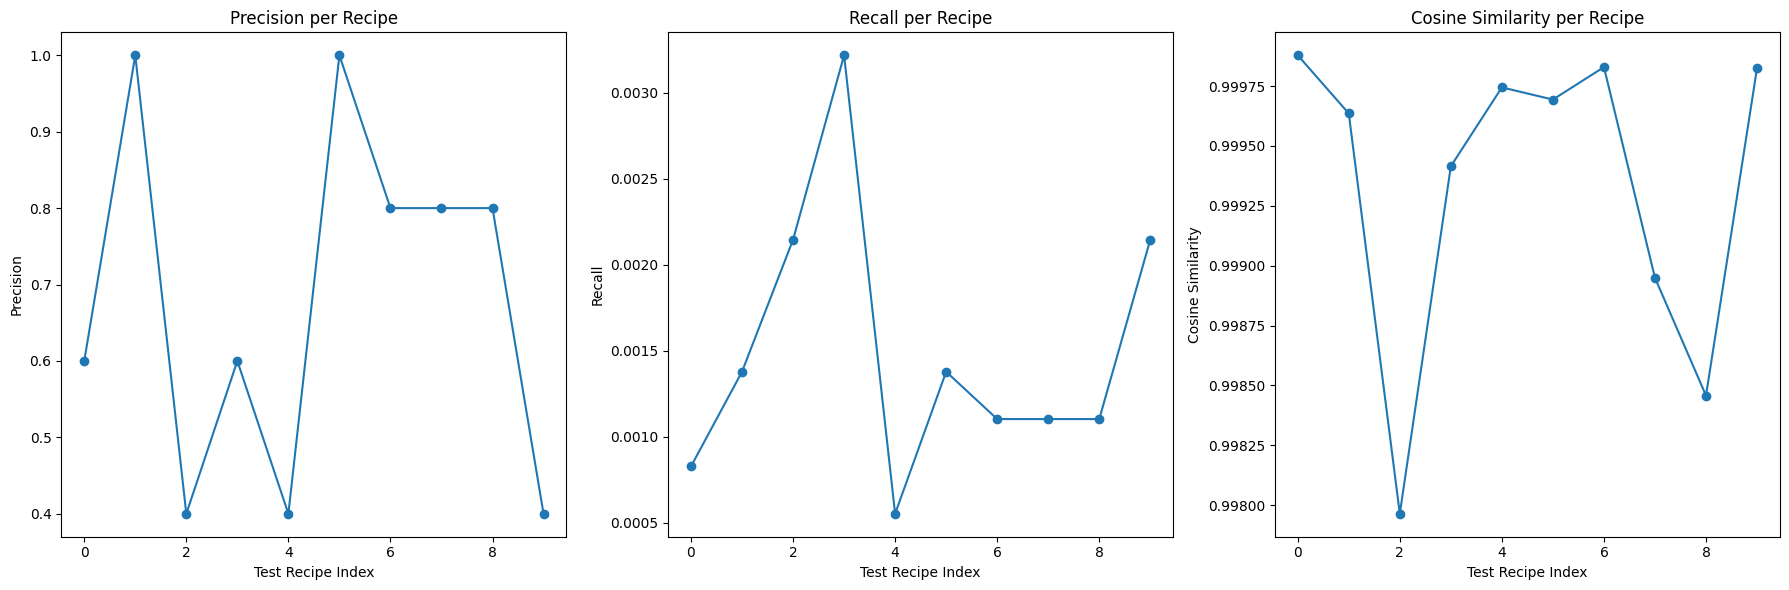

Average Precision: 0.68
Average Recall: 0.00
Average Cosine Similarity: 1.00


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing recipes
# Tokenize the ingredients into lists of words
df['ingredients_tokens'] = df['ingredients_name'].apply(lambda x: x.lower().split(', '))

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=df['ingredients_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector for an ingredient
def get_ingredient_vector(ingredient, model):
    try:
        return model.wv[ingredient]
    except KeyError:
        # Return a zero vector if the ingredient is not in the vocabulary
        return np.zeros(model.vector_size)

# Function to get the vector for a list of ingredients
def get_recipe_vector(ingredients_list, model):
    vectors = [get_ingredient_vector(ing, model) for ing in ingredients_list]
    return np.mean(vectors, axis=0)

# Recommendation function
def recommend_word2vec(input_ingredients, top_n=5):
    input_tokens = input_ingredients.lower().split(', ')
    input_vec = get_recipe_vector(input_tokens, word2vec_model)
    # Calculate cosine similarity with all recipes
    similarities = []
    for _, row in df.iterrows():
        recipe_vec = get_recipe_vector(row['ingredients_tokens'], word2vec_model)
        similarity = np.dot(input_vec, recipe_vec) / (np.linalg.norm(input_vec) * np.linalg.norm(recipe_vec))
        similarities.append(similarity)
    # Get top-k recommendations
    df['similarity'] = similarities
    recommendations = df.sort_values(by='similarity', ascending=False).head(top_n)
    return recommendations[['name', 'ingredients_name', 'similarity']]

# Example usage
input_ingredients = "chicken, garlic, yogurt"
print("\nWord2Vec Recommendations:")
print(recommend_word2vec(input_ingredients))

# Evaluation
test_set = df.sample(n=10, random_state=42)  # Sample 10 recipes as test set
precisions = []
recalls = []
cosine_similarities = []

for idx, test_row in test_set.iterrows():
    true_relevant_recipes = df[df['category'] == test_row['category']]  # Assuming 'category' is a column indicating relevance
    input_ingredients = test_row['ingredients_name']
    recommendations = recommend_word2vec(input_ingredients, top_n=5)

    # Calculate precision
    num_relevant_recommendations = sum([1 for rec in recommendations['name'] if rec in true_relevant_recipes['name'].values])
    precision = num_relevant_recommendations / len(recommendations)
    precisions.append(precision)

    # Calculate recall
    total_relevant_recipes = len(true_relevant_recipes)
    recall = num_relevant_recommendations / total_relevant_recipes
    recalls.append(recall)

    # Calculate average cosine similarity
    avg_cosine_similarity = recommendations['similarity'].mean()
    cosine_similarities.append(avg_cosine_similarity)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(range(len(test_set)), precisions, marker='o')
axs[0].set_title('Precision per Recipe')
axs[0].set_xlabel('Test Recipe Index')
axs[0].set_ylabel('Precision')

axs[1].plot(range(len(test_set)), recalls, marker='o')
axs[1].set_title('Recall per Recipe')
axs[1].set_xlabel('Test Recipe Index')
axs[1].set_ylabel('Recall')

axs[2].plot(range(len(test_set)), cosine_similarities, marker='o')
axs[2].set_title('Cosine Similarity per Recipe')
axs[2].set_xlabel('Test Recipe Index')
axs[2].set_ylabel('Cosine Similarity')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Recall: {np.mean(recalls):.2f}")
print(f"Average Cosine Similarity: {np.mean(cosine_similarities):.2f}")

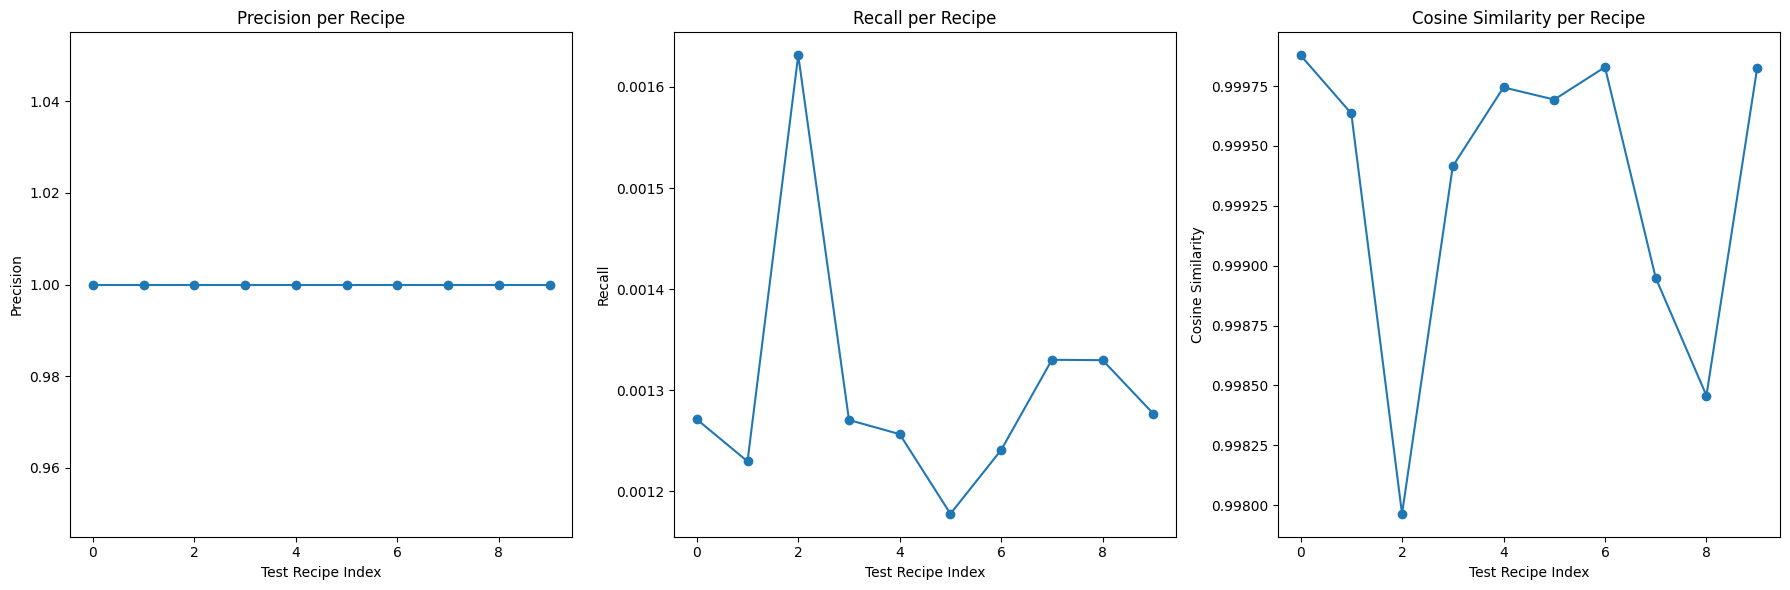

Average Precision: 1.00
Average Recall: 0.00
Average Cosine Similarity: 1.00


In [ ]:
# Evaluation
test_set = df.sample(n=10, random_state=42)  # Sample 10 recipes as test set
precisions = []
recalls = []
cosine_similarities = []

for idx, test_row in test_set.iterrows():
    input_ingredients = set(test_row['ingredients_name'].lower().split(', '))
    true_relevant_recipes = df[df['ingredients_name'].apply(lambda x: any(ing in input_ingredients for ing in x.lower().split(', ')))]

    recommendations = recommend_word2vec(test_row['ingredients_name'], top_n=5)

    # Calculate precision
    num_relevant_recommendations = sum([1 for rec in recommendations['name'] if rec in true_relevant_recipes['name'].values])
    precision = num_relevant_recommendations / len(recommendations)
    precisions.append(precision)

    # Calculate recall
    total_relevant_recipes = len(true_relevant_recipes)
    recall = num_relevant_recommendations / total_relevant_recipes if total_relevant_recipes > 0 else 0
    recalls.append(recall)

    # Calculate average cosine similarity
    avg_cosine_similarity = recommendations['similarity'].mean()
    cosine_similarities.append(avg_cosine_similarity)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(range(len(test_set)), precisions, marker='o')
axs[0].set_title('Precision per Recipe')
axs[0].set_xlabel('Test Recipe Index')
axs[0].set_ylabel('Precision')

axs[1].plot(range(len(test_set)), recalls, marker='o')
axs[1].set_title('Recall per Recipe')
axs[1].set_xlabel('Test Recipe Index')
axs[1].set_ylabel('Recall')

axs[2].plot(range(len(test_set)), cosine_similarities, marker='o')
axs[2].set_title('Cosine Similarity per Recipe')
axs[2].set_xlabel('Test Recipe Index')
axs[2].set_ylabel('Cosine Similarity')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Recall: {np.mean(recalls):.2f}")
print(f"Average Cosine Similarity: {np.mean(cosine_similarities):.2f}")

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Load and preprocess the data
df = pd.read_csv('Food_Recipe.csv')  # Replace with your dataset path

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_ingredients(ingredients):
    ingredients = ingredients.lower()
    tokens = ingredients.split(', ')
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

df['ingredients_tokens'] = df['ingredients_name'].apply(preprocess_ingredients)

# Train a Word2Vec model with optimized parameters
word2vec_model = Word2Vec(sentences=df['ingredients_tokens'], vector_size=200, window=7, min_count=1, workers=4, sg=1)

# Function to get the vector for an ingredient
def get_ingredient_vector(ingredient, model):
    try:
        return model.wv[ingredient]
    except KeyError:
        return np.zeros(model.vector_size)

# Function to get the vector for a list of ingredients
def get_recipe_vector(ingredients_list, model):
    vectors = [get_ingredient_vector(ing, model) for ing in ingredients_list]
    return np.mean(vectors, axis=0)

# Recommendation function
def recommend_word2vec(input_ingredients, top_n=5):
    input_tokens = preprocess_ingredients(input_ingredients)
    input_vec = get_recipe_vector(input_tokens, word2vec_model)
    similarities = []
    for _, row in df.iterrows():
        recipe_vec = get_recipe_vector(row['ingredients_tokens'], word2vec_model)
        similarity = np.dot(input_vec, recipe_vec) / (np.linalg.norm(input_vec) * np.linalg.norm(recipe_vec))
        similarities.append(similarity)
    df['similarity'] = similarities
    recommendations = df.sort_values(by='similarity', ascending=False).head(top_n)
    return recommendations[['name', 'ingredients_name', 'similarity']]

# Example usage
input_ingredients = "chicken, garlic, yogurt"
print("\nWord2Vec Recommendations:")
print(recommend_word2vec(input_ingredients))

# Evaluation
test_set = df.sample(n=10, random_state=42)
precisions = []
recalls = []
cosine_similarities = []

for idx, test_row in test_set.iterrows():
    true_relevant_recipes = df[df['category'] == test_row['category']]
    input_ingredients = test_row['ingredients_name']
    recommendations = recommend_word2vec(input_ingredients, top_n=5)

    num_relevant_recommendations = sum([1 for rec in recommendations['name'] if rec in true_relevant_recipes['name'].values])
    precision = num_relevant_recommendations / len(recommendations)
    precisions.append(precision)

    total_relevant_recipes = len(true_relevant_recipes)
    recall = num_relevant_recommendations / total_relevant_recipes
    recalls.append(recall)

    avg_cosine_similarity = recommendations['similarity'].mean()
    cosine_similarities.append(avg_cosine_similarity)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(range(len(test_set)), precisions, marker='o')
axs[0].set_title('Precision per Recipe')
axs[0].set_xlabel('Test Recipe Index')
axs[0].set_ylabel('Precision')

axs[1].plot(range(len(test_set)), recalls, marker='o')
axs[1].set_title('Recall per Recipe')
axs[1].set_xlabel('Test Recipe Index')
axs[1].set_ylabel('Recall')

axs[2].plot(range(len(test_set)), cosine_similarities, marker='o')
axs[2].set_title('Cosine Similarity per Recipe')
axs[2].set_xlabel('Test Recipe Index')
axs[2].set_ylabel('Cosine Similarity')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Recall: {np.mean(recalls):.2f}")
print(f"Average Cosine Similarity: {np.mean(cosine_similarities):.2f}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# Load and preprocess the data
df = pd.read_csv('Food_Recipe.csv')  # Replace with your dataset path

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_ingredients(ingredients):
    # Ensure the input is a string; if not, return an empty list
    if isinstance(ingredients, str):
        ingredients = ingredients.lower()
        tokens = ingredients.split(', ')
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return tokens
    else:
        return []

df['ingredients_tokens'] = df['ingredients_name'].apply(preprocess_ingredients)

# Train a Word2Vec model with optimized parameters
word2vec_model = Word2Vec(sentences=df['ingredients_tokens'], vector_size=200, window=7, min_count=1, workers=4, sg=1)

# Function to get the vector for an ingredient
def get_ingredient_vector(ingredient, model):
    try:
        return model.wv[ingredient]
    except KeyError:
        return np.zeros(model.vector_size)

# Function to get the vector for a list of ingredients
def get_recipe_vector(ingredients_list, model):
    vectors = [get_ingredient_vector(ing, model) for ing in ingredients_list]
    return np.mean(vectors, axis=0)

# Recommendation function
def recommend_word2vec(input_ingredients, top_n=5):
    input_tokens = preprocess_ingredients(input_ingredients)
    input_vec = get_recipe_vector(input_tokens, word2vec_model)
    similarities = []
    for _, row in df.iterrows():
        recipe_vec = get_recipe_vector(row['ingredients_tokens'], word2vec_model)
        similarity = np.dot(input_vec, recipe_vec) / (np.linalg.norm(input_vec) * np.linalg.norm(recipe_vec))
        similarities.append(similarity)
    df['similarity'] = similarities
    recommendations = df.sort_values(by='similarity', ascending=False).head(top_n)
    return recommendations[['name', 'ingredients_name', 'similarity']]

# Example usage
input_ingredients = "chicken, garlic, yogurt"
print("\nWord2Vec Recommendations:")
print(recommend_word2vec(input_ingredients))

# Evaluation
test_set = df.sample(n=10, random_state=42)
precisions = []
recalls = []
cosine_similarities = []

for idx, test_row in test_set.iterrows():
    true_relevant_recipes = df[df['category'] == test_row['category']]
    input_ingredients = test_row['ingredients_name']
    recommendations = recommend_word2vec(input_ingredients, top_n=5)

    num_relevant_recommendations = sum([1 for rec in recommendations['name'] if rec in true_relevant_recipes['name'].values])
    precision = num_relevant_recommendations / len(recommendations)
    precisions.append(precision)

    total_relevant_recipes = len(true_relevant_recipes)
    recall = num_relevant_recommendations / total_relevant_recipes
    recalls.append(recall)

    avg_cosine_similarity = recommendations['similarity'].mean()
    cosine_similarities.append(avg_cosine_similarity)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(range(len(test_set)), precisions, marker='o')
axs[0].set_title('Precision per Recipe')
axs[0].set_xlabel('Test Recipe Index')
axs[0].set_ylabel('Precision')

axs[1].plot(range(len(test_set)), recalls, marker='o')
axs[1].set_title('Recall per Recipe')
axs[1].set_xlabel('Test Recipe Index')
axs[1].set_ylabel('Recall')

axs[2].plot(range(len(test_set)), cosine_similarities, marker='o')
axs[2].set_title('Cosine Similarity per Recipe')
axs[2].set_xlabel('Test Recipe Index')
axs[2].set_ylabel('Cosine Similarity')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Recall: {np.mean(recalls):.2f}")
print(f"Average Cosine Similarity: {np.mean(cosine_similarities):.2f}")


Word2Vec Recommendations:


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
def preprocess_ingredients_with_category(ingredients, category):
    tokens = preprocess_ingredients(ingredients)
    if tokens:
        tokens.append(category.lower())  # Add category as a token
    return tokens

df['ingredients_tokens'] = df.apply(lambda row: preprocess_ingredients_with_category(row['ingredients_name'], row['category']), axis=1)

In [ ]:
df = df[df['ingredients_name'].apply(lambda x: isinstance(x, str) and len(preprocess_ingredients(x)) > 0)]

In [ ]:
word2vec_model = Word2Vec(
    sentences=df['ingredients_tokens'],
    vector_size=200,
    window=5,  # Reduce window size to focus on local context
    min_count=2,  # Ignore rare ingredients
    workers=4,
    sg=1
)

In [ ]:
def recommend_word2vec(input_ingredients, top_n=5):
    input_tokens = preprocess_ingredients(input_ingredients)
    input_vec = get_recipe_vector(input_tokens, word2vec_model)

    # Skip if input vector is all zeros
    if np.all(input_vec == 0):
        print("Input vector is all zeros. No recommendations available.")
        return pd.DataFrame(columns=['name', 'ingredients_name', 'similarity'])

    similarities = []
    for _, row in df.iterrows():
        recipe_vec = get_recipe_vector(row['ingredients_tokens'], word2vec_model)

        # Skip recipes with zero vectors
        if np.all(recipe_vec == 0):
            similarities.append(-1)  # Assign a low similarity score
            continue

        # Compute cosine similarity with smoothing
        similarity = max(0, np.dot(input_vec, recipe_vec) / (np.linalg.norm(input_vec) * np.linalg.norm(recipe_vec)))
        similarities.append(similarity)

    # Add similarity scores to DataFrame
    df['similarity'] = similarities

    # Filter out invalid similarities (-1 values)
    valid_df = df[df['similarity'] != -1]

    # Sort and return top N recommendations
    recommendations = valid_df.sort_values(by='similarity', ascending=False).head(top_n)
    return recommendations[['name', 'ingredients_name', 'similarity']]

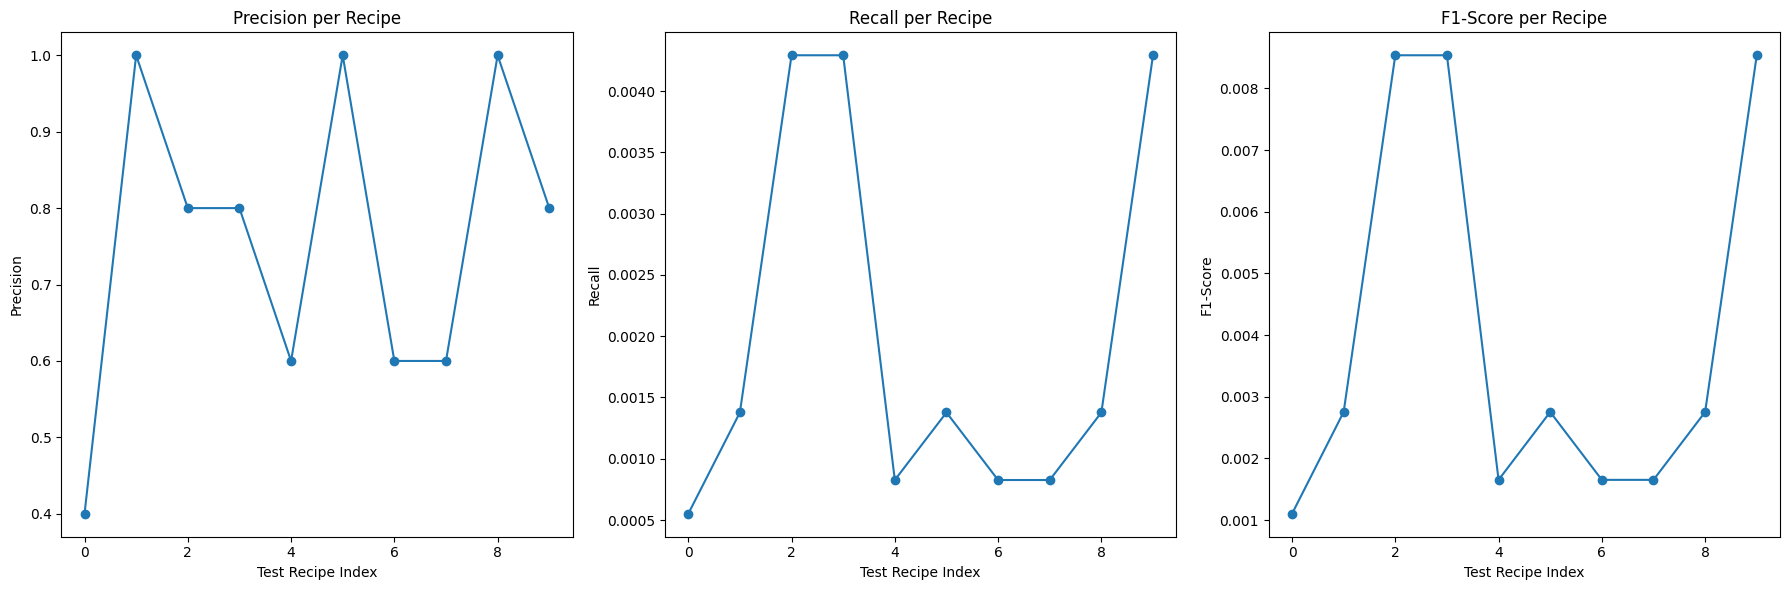

Average Precision: 0.76
Average Recall: 0.00
Average F1-Score: 0.00


In [ ]:
# Evaluation
test_set = df.sample(n=10, random_state=42)
precisions = []
recalls = []
f1_scores = []

for idx, test_row in test_set.iterrows():
    true_category = test_row['category']
    input_ingredients = test_row['ingredients_name']
    recommendations = recommend_word2vec(input_ingredients, top_n=5)

    if recommendations.empty:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)
        continue

    num_relevant_recommendations = sum([1 for rec in recommendations['name'] if df.loc[df['name'] == rec, 'category'].values[0] == true_category])
    precision = num_relevant_recommendations / len(recommendations)
    total_relevant_recipes = len(df[df['category'] == true_category])
    recall = num_relevant_recommendations / total_relevant_recipes if total_relevant_recipes > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].plot(range(len(test_set)), precisions, marker='o')
axs[0].set_title('Precision per Recipe')
axs[0].set_xlabel('Test Recipe Index')
axs[0].set_ylabel('Precision')

axs[1].plot(range(len(test_set)), recalls, marker='o')
axs[1].set_title('Recall per Recipe')
axs[1].set_xlabel('Test Recipe Index')
axs[1].set_ylabel('Recall')

axs[2].plot(range(len(test_set)), f1_scores, marker='o')
axs[2].set_title('F1-Score per Recipe')
axs[2].set_xlabel('Test Recipe Index')
axs[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

# Print average metrics
print(f"Average Precision: {np.mean(precisions):.2f}")
print(f"Average Recall: {np.mean(recalls):.2f}")
print(f"Average F1-Score: {np.mean(f1_scores):.2f}")